# Transformers

&emsp; Transformers, a game-changing development in machine learning, emerged in 2017 with the paper **"Attention Is All You Need"** by Vaswani et al. These models have notably impacted the field, excelling in natural language processing **(NLP)** tasks like **translation**, **sentiment analysis**, and **text summarization**. Famous Transformers include **BERT**, **GPT-3**, and **RoBERTa**.

Here are some of the key features of Transformers that make them so powerful:

- Transformers effectively **capture long-range correlation** in the data, a challenge for RNNs.
- They employ **self-attention mechanisms** to process and contextualize information across the entire sequence.
- Unlike RNNs, Transformers are **parallelizable** and thus more efficient to train.

In [1]:
# defaults imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

import numpy as np
from tqdm import tqdm, trange
from time import time, sleep
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, top_k_accuracy_score

In [2]:
# Some constants
x = torch.randn(256, 28, 28)
repeat = 100_000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

## Key Concepts and Components

&emsp; Transformers are composed of several key components, including **self-attention**, **multi-head attention**, **masked attention**, **positional encoding** etc. These components are stacked together to form the Transformer architecture.

<!-- ![Transformer Architecture](trying_to_make_transformer.svg) -->

### Vanilla Self-Attention Mechanism

Self-attention is the basic building block of transformer models. Let us first understand the concept of self-attention without any learnable weights.

&emsp; Let us take the example of some NLP task to understand the concept of self-attention. Let us have a sentences of length $n$. Also for each word in the sentence, we have a vector of length $k$. So this sentence can be represented as a matrix of size ($n \times k$). Let us call this matrix $X_{n \times k}$. <span style="font-size: 12px">(we are not considering the batch dimension for simplicity)</span>

#### Step 1:

&emsp; We multiply $X$ with its transpose to get a matrix of size ($n \times n$). Let us call this matrix $W_{n\times n}$. This operation can be thought of as a similarity measure between each word in the sentence with every other word in the sentence. The diagonal elements of $W_{n\times n}$ will be the similarity of each word with itself. The off-diagonal elements will be the similarity of each word with every other word in the sentence.

$$
W_{n\times n} := X_{n \times k} \times X_{k \times n}^T
$$

**How come the product of the two word embeddings gives the similarity between the two words?** (cosine similarity is equal to the dot product of two unit vectors)



#### Step 2:

&emsp; In this step, we scale the result by $\frac{1}{\sqrt{k}}$ ([why?](error_proof.ipynb)), and  apply a softmax function to each column of $W_{n\times n}$. This step can be thought of as a way to normalize the similarity scores. After completing this step, we get an updated $W_{n\times n}$ matrix.

$$
W_{n\times n} := \text{softmax}\left(\frac{W_{n\times n}}{\sqrt{k}}\right)
$$

#### Step 3:

&emsp; In this step, we multiply the updated $W_{n\times n}$ with $X_{n \times k}$ to get a matrix of size ($n \times k$). Let us call this matrix $Y_{n \times k}$. This step can be thought of as a weighted sum of the vectors in $X_{n \times k}$, where the weights are the values in $W_{n\times n}$. Thus as the new matrix $Y_{n \times k}$, we have a matrix which has the same shape as $X_{n \times k}$, but instead of telling about each word in the sentence, it tells about the importance of each word in the sentence in the context of every other word in the sentence.

$$
Y_{n \times k} := W_{n\times n} \times X_{n \times k}
$$

In [3]:
class VanillaSelfAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # size of x is expected to be [batch_size, seq_len=n, embedding_dim=k]
        w = x @ x.transpose(-1, -2)  # w.size() = [batch_size, n, n]
        w = w / torch.sqrt(torch.tensor(x.shape[-1]).float())  # w / sqrt(k)
        w = F.softmax(w, dim=-1)
        y = w @ x  # y.size() = [batch_size, n, k]
        return y

model = VanillaSelfAttention()
with torch.no_grad():
    t0 = time()
    for i in trange(repeat, leave=False):
        y = model(x)
    print(f"VanillaSelfAttention: {((time() - t0)*1e6/repeat):.2f} us")

VanillaSelfAttention: 248.46 us


### Self-Attention with Weights

Now, as we know the concept of self Attention, we can extend it to self-attention with weights. In this case, we have three weight matrices $W^Q$, $W^K$, and $W^V$ all of shapes ($k \times d$). Here $d$ is the output dimension. The next calculation is similar to the previous one and is shown below.

$Q_{n \times d} := X_{n \times k} \times W_{k \times d}^Q$<br>
$K_{n \times d} := X_{n \times k} \times W_{k \times d}^K$<br>
$V_{n \times d} := X_{n \times k} \times W_{k \times d}^V$

$W_{n\times n}  := Q_{n\times d} \times K_{d \times n}^T$<br>
$W_{n\times n}  := \text{softmax}\left(\frac{W_{n\times n}}{\sqrt{d}}\right)$<br>
$Y_{n \times d} := W_{n\times n} \times V_{n \times d}$

Note that, in case of self-attention without weights, the shape of $Y$ remained same as $X$ both ($n \times k$). But in case of self-attention with weights, the shape of $X$ is ($n \times k$) and the shape of $Y$ is ($n \times d$). It is as if, the embedding dimension of each word in the sentence has been changed from $k$ to $d$.

In [4]:
# Without using linear layers

class SelfAttention(nn.Module):
    def __init__(self, input_dim, output_dim=None):
        super().__init__()
        if output_dim is None: output_dim = input_dim
        Wq = torch.empty(input_dim, output_dim)
        Wk = torch.empty(input_dim, output_dim)
        Wv = torch.empty(input_dim, output_dim)

        torch.nn.init.xavier_uniform_(Wq)
        torch.nn.init.xavier_uniform_(Wk)
        torch.nn.init.xavier_uniform_(Wv)

        self.Wq = nn.Parameter(Wq)
        self.Wk = nn.Parameter(Wk)
        self.Wv = nn.Parameter(Wv)

    def forward(self, x):
        # sixe of x is expected to be [batch_size, seq_len=n, input_dim=k]
        Q = x @ self.Wq  # q.size() = [batch_size, n, output_dim=d]
        K = x @ self.Wk  # k.size() = [batch_size, n, output_dim=d]
        V = x @ self.Wv  # v.size() = [batch_size, n, output_dim=d]

        w = Q @ K.transpose(-1, -2)  # w.size() = [batch_size, n, n]
        w = w / torch.sqrt(torch.tensor(x.shape[-1]).float())
        w = F.softmax(w, dim=-1)
        y = w @ V
        return y

model = SelfAttention(28, 28)
with torch.no_grad():
    t0 = time()
    for i in trange(repeat, leave=False):
        with torch.no_grad():
            y = model(x)
    print(f"SelfAttention without using linear layers: {((time() - t0)*1e6/repeat):.2f} us")

SelfAttention without using linear layers: 374.36 us


In [5]:
# with using linear layers

class SelfAttention(nn.Module):
    def __init__(self, input_dim, output_dim=None):
        super().__init__()
        if output_dim is None: output_dim = input_dim
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.Wq = nn.Linear(input_dim, output_dim, bias=False)
        self.Wk = nn.Linear(input_dim, output_dim, bias=False)
        self.Wv = nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, x):
        # sixe of x is expected to be [batch_size, seq_len=n, input_dim=k]
        Q = self.Wq(x)  # q.size() = [batch_size, n, output_dim=d]
        K = self.Wk(x)  # k.size() = [batch_size, n, output_dim=d]
        V = self.Wv(x)  # v.size() = [batch_size, n, output_dim=d]

        w = Q @ K.transpose(-1, -2)  # w.size() = [batch_size, n, n]
        w = w / torch.sqrt(torch.tensor(self.input_dim).float())
        w = F.softmax(w, dim=-1)
        y = w @ V
        return y

model = SelfAttention(28, 28)
with torch.no_grad():
    t0 = time()
    for i in trange(repeat, leave=False):
        y = model(x)
    print(f"SelfAttention using linear layers: {((time() - t0)*1e6/repeat):.2f} us")

SelfAttention using linear layers: 344.21 us


From experiments we get that implementation using linear layer is slower than manual implementation. So, we will stick to manual implementation.

### Multi-Head Attention

In multi-head attention, we have multiple self-attention layers in parallel. Each of these layers has its own set of weights. The output of each of these layers is concatenated and then passed through a linear layer. The output of this linear layer is the final output of the multi-head attention layer. 

Suppose there are $h$ heads in the multi-head attention layer, and we take d as the output dimension for the multi-head attention layer. Incase we use $d$ as the output dimension for each head, the output from each heads will be of shape ($n \times d$). The output of all these heads concatenated will be of shape ($n \times d*h$). But we wanted the output of the multi-head attention layer to be of shape ($n \times d$). So, instead of using $d$ as the output dimension for each head, we use $\frac{d}{h}$ as the output dimension for each head. Thus the output of each head will be of shape ($n \times \frac{d}{h}$). The output of all these heads concatenated will be of shape ($n \times d$). <span style="font-size: 12px">(assuming h divides d perfectly)</span>

In [6]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        assert output_dim % num_heads == 0, f"{output_dim = } must be divisible by {num_heads = }"
        self.head_dim = output_dim // num_heads

        # nothing fancy, just initializing the weights
        Wq = torch.empty(input_dim, output_dim)
        Wk = torch.empty(input_dim, output_dim)
        Wv = torch.empty(input_dim, output_dim)
        torch.nn.init.xavier_uniform_(Wq)
        torch.nn.init.xavier_uniform_(Wk)
        torch.nn.init.xavier_uniform_(Wv)
        self.Wq = nn.Parameter(Wq)
        self.Wk = nn.Parameter(Wk)
        self.Wv = nn.Parameter(Wv)

        self.fc_out = nn.Linear(output_dim, output_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        Q = x @ self.Wq
        K = x @ self.Wk
        V = x @ self.Wv

        Q = Q.reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        K = K.reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        V = V.reshape(batch_size, seq_len, self.num_heads, self.head_dim)

        w = torch.einsum("nqhd,nkhd->nhqk", [Q, K])
        w = w / torch.sqrt(torch.tensor(self.head_dim).float())
        w = F.softmax(w, dim=-1)
        y = torch.einsum("nhql,nlhd->nqhd", [w, V])
        y = y.reshape(batch_size, seq_len, -1)  # [batch_size, seq_len, output_dim]

        out = self.fc_out(y)

        return out

model = MultiHeadAttention(28, 28, 4)
with torch.no_grad():
    t0 = time()
    for i in trange(repeat, leave=False):
        y = model(x)
    print(f"MultiHeadAttention: {((time() - t0)*1e6/repeat):.2f} us")

MultiHeadAttention: 1059.36 us


### Masked Attention

As explained in step 2 of the vanilla self-attention mechanism, we scale the matrix $W_{n\times n}$ by $\frac{1}{\sqrt{k}}$ and then apply a softmax function to each column of $W_{n\times n}$. Here between scaling down the matrix and applying the softmax function, we do the masking.

**Motivation:** In the case of language translation, we do not want the model to look at the words that come after the word that we are trying to translate. (For example, if we are trying to predict the next part of the sentence "I am going to the", we do not want the model to look at the words "childrens park" as it comes after the word "the". So we mask the words that come after the word that we are trying to predict. Now, in the next go, we will show it the word "childrens", and would expect it to predict just the word "park". So we mask the words that come after the word "childrens". This is called masking.)

**How do we do masking?** We make the upper traiangular part of the matrix $W_{n\times n}$ equal to $-\infty$. This is done so that when we apply the softmax function, the values in the upper triangular part of the matrix become zero, and the the full probability mask is distributed only among the lower triangular part of the matrix.

In [7]:
class MaskedMultiHeadAttention(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        assert output_dim % num_heads == 0, f"{output_dim = } must be divisible by {num_heads = }"
        self.head_dim = output_dim // num_heads

        # nothing fancy, just initializing the weights
        Wq = torch.empty(input_dim, output_dim)
        Wk = torch.empty(input_dim, output_dim)
        Wv = torch.empty(input_dim, output_dim)
        torch.nn.init.xavier_uniform_(Wq)
        torch.nn.init.xavier_uniform_(Wk)
        torch.nn.init.xavier_uniform_(Wv)
        self.Wq = nn.Parameter(Wq)
        self.Wk = nn.Parameter(Wk)
        self.Wv = nn.Parameter(Wv)

        self.fc_out = nn.Linear(output_dim, output_dim)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        Q = x @ self.Wq
        K = x @ self.Wk
        V = x @ self.Wv

        Q = Q.reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        K = K.reshape(batch_size, seq_len, self.num_heads, self.head_dim)
        V = V.reshape(batch_size, seq_len, self.num_heads, self.head_dim)

        w = torch.einsum("nqhd,nkhd->nhqk", [Q, K])
        w = w / torch.sqrt(torch.tensor(self.head_dim).float())

        mask = torch.tril(torch.ones(seq_len, seq_len)) == 0
        w = w.masked_fill(mask, float("-inf"))

        w = F.softmax(w, dim=-1)
        y = torch.einsum("nhql,nlhd->nqhd", [w, V])
        y = y.reshape(batch_size, seq_len, -1)  # [batch_size, seq_len, output_dim]

        out = self.fc_out(y)

        return out

model = MaskedMultiHeadAttention(28, 28, 4)
with torch.no_grad():
    t0 = time()
    for i in trange(repeat, leave=False):
        y = model(x)
    print(f"MaskedMultiHeadAttention: {((time() - t0)*1e6/repeat):.2f} us")

MaskedMultiHeadAttention: 1077.41 us


### Positional Encoding

Adhil has already explained this in detail, I am not going to repeat the whole here, but I will just give a brief overview of the concept.

- Positional embedding vector is a vector of same shape as the input embeding vector and it's values don't change with the input.
- It carries information about the position of the word in the sentence.
- We element-wise add the positional embedding vector to the input embedding vector to get the final embedding vector for each word in the sentence.
- Thus we get a new embedding vector which carries information about the word itself as well as its position in the sentence.

## Transformer Architecture

&emsp; We would build a small transformer model to understand the architecture of the transformer. The transformer model that we are going to build is shown below.

<!-- ![Transformer Block](transformer_block.png) -->
<img src="transformer_block.png" alt="transformer block" width="200"/>

In [8]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads=8, dropout=0.1, forward_expansion=1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_size, embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.dropout = nn.Dropout(dropout)

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_size, int(forward_expansion * embed_size)),
            nn.ReLU(),
            nn.Linear(int(forward_expansion * embed_size), embed_size),
        )

        self.norm2 = nn.LayerNorm(embed_size)

    def forward(self, x):
        attention = self.attention(x)
        x = self.dropout(self.norm1(attention + x))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out

class Model(nn.Module):
    def __init__(self, embed_size=28, num_classes=10, heads=4, forward_expansion=1, dropout=0.1):
        super(Model, self).__init__()
        self.embed_size = embed_size
        self.num_classes = num_classes

        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion)
        self.fc_out = nn.Linear(embed_size*embed_size, num_classes)

    def forward(self, x):
        out = self.transformer_block(x)
        out = out.flatten(start_dim=1)
        out = self.fc_out(out)
        return F.softmax(out, dim=-1)

In [9]:
def get_accuracy(
    model,
    data_generator,
    GPU = torch.device("cpu"),
    n = np.inf,
):
    model.eval()
    with torch.no_grad():
        accs = []
        j = 0
        for batch_x, batch_y in data_generator:
            batch_x, batch_y = batch_x.to(GPU), batch_y.flatten()
            acc = accuracy_score(batch_y.numpy(), model(batch_x).argmax(1).cpu().numpy())
            accs.append(acc*100)
            j += 1
            if j == n: break
    model.train()
    return np.array(accs).mean()

In [10]:
torch.manual_seed(21)
model = Model().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    lambda x: x.squeeze()
])

train_data = torchvision.datasets.MNIST("/home/aritra/project/AML_HW/mnist", train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST("/home/aritra/project/AML_HW/mnist", train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True,  num_workers=16, pin_memory=True)
test_loader =  torch.utils.data.DataLoader(test_data,  batch_size=128, shuffle=False, num_workers=16, pin_memory=True)
losses = []
train_accuracies = []
test_accuracies = []

In [11]:
for epoch in trange(500):
    for x_data, y_data in train_loader:
        # print(x_data, y_data)
        x_data, y_data = x_data.float().to(DEVICE), y_data.long().to(DEVICE)
        y_data = torch.nn.functional.one_hot(y_data, 10).float()
        optimizer.zero_grad()
        outputs = model(x_data)
        loss = loss_fn(outputs.float(), y_data)
        loss.backward()
        optimizer.step()

    train_accuracies.append(get_accuracy(model, train_loader, DEVICE))
    test_accuracies.append(get_accuracy(model, test_loader, DEVICE))

    losses.append(loss.item())

100%|██████████| 500/500 [18:17<00:00,  2.20s/it]


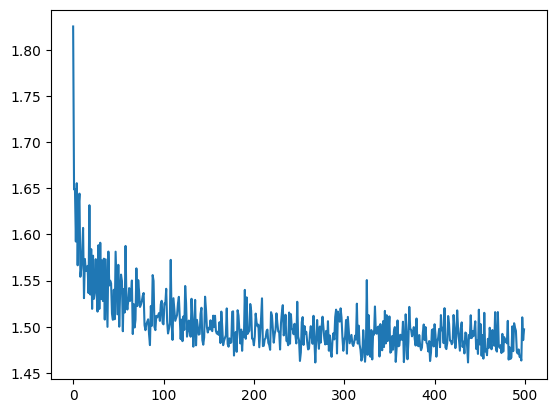

In [12]:
plt.plot(losses)

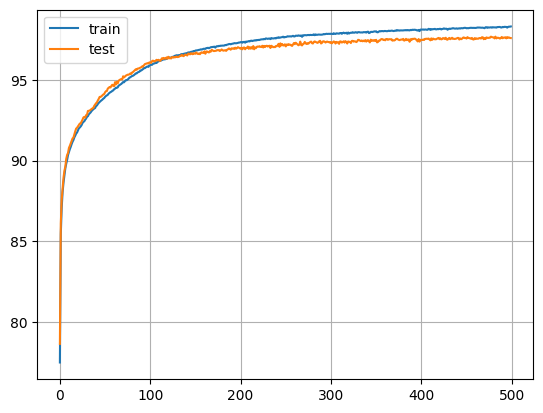

In [13]:
plt.plot(train_accuracies, label="train")
plt.plot(test_accuracies, label="test")
plt.grid()
plt.legend()